# Inference Using Mask R-CNN

Use Mask R-CNN pretrained on the COCO dataset to perform inference on the WAD test set.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of COCO images to run detection on (We will use a different directory later)
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

print(COCO_MODEL_PATH)

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


/home/stevenzc/Mask_RCNN/mask_rcnn_coco.h5


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9

## Create Model and Load Trained Weights

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [4]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

print('car', class_names.index('car'))
print('motorcycle', class_names.index('motorcycle'))
print('bicycle', class_names.index('bicycle'))
print('person', class_names.index('person'))
print('truck', class_names.index('truck'))
print('bus', class_names.index('bus'))
# print('tricycle', class_names.index('tricycle'))

# since COCO does not have a tricycle class, we will not predict tricycle



car 3
motorcycle 4
bicycle 2
person 1
truck 8
bus 6


## Run Object Detection

Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


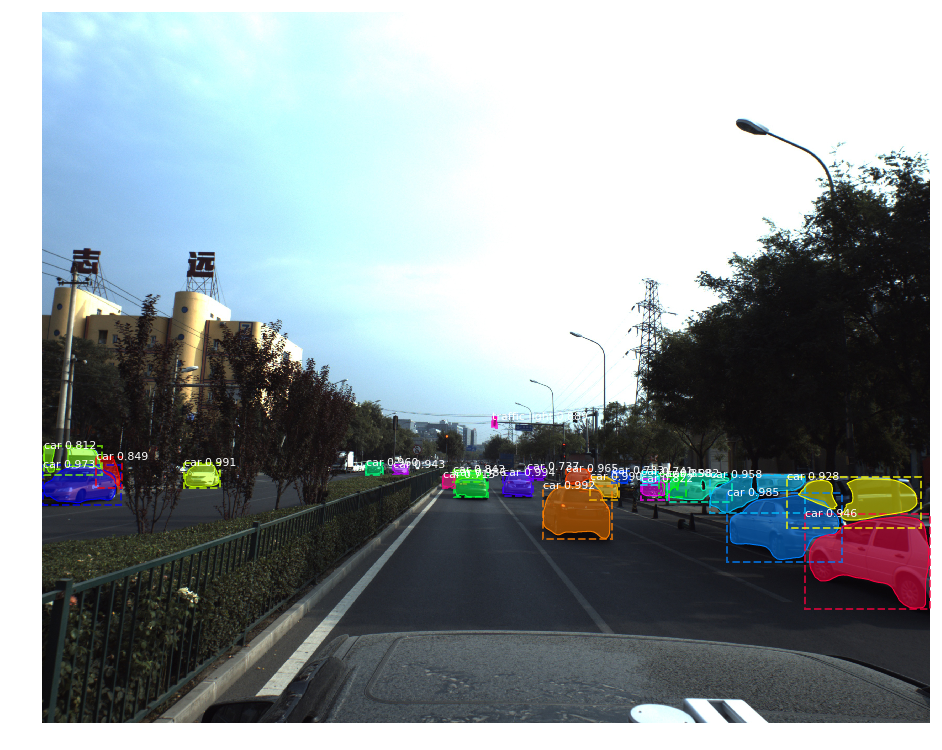

In [7]:
# Load a random image from the images folder
WAD_IM = "/home/stevenzc/.kaggle/competitions/cvpr-2018-autonomous-driving/test/85102456a197dc73e4125820d45d7c35.jpg"

file_names = next(os.walk(IMAGE_DIR))[2]
# image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

image = skimage.io.imread(WAD_IM)

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [16]:
def rle(mask):
    """Produces the WAD challenge run-length encoding format from a binary mask.
    
    Inputs:
        mask - 2D numpy binary mask array
    
    Returns:
        rle_str - RLE string in WAD submission format, zero indexed, | delimited
    """
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    # find locations where the run length changes
    runs = np.where(pixels[1:] != pixels[:-1])[0]
    runs[1::2] -= runs[::2]
    pieces = []
    
    for left, right in zip(runs[::2], runs[1::2]):
        pieces.append(str(left) + ' ' + str(right) + '|')
    
    return ''.join(pieces)

    
sample_mask = np.array([[1, 0, 0],
                       [1, 1, 1],
                       [0, 1, 1]])

print(rle(sample_mask))
print(np.sum(sample_mask))

0 1|3 3|7 2|
6


In [15]:
# translate between coco class ids (the keys) to wad class ids (the values)

coco_to_wad = {
    3: 33,
    4: 34,
    2: 35,
    1: 36,
    8: 38,
    6: 39  
    # no tricycles are classified, for now
}

#### Create the submission CSV

Creating the submission CSV took about 2 hours on a single K80 GPU.
Speed is about 3 seconds per image.

TODO: it may be faster to do 2 images per batch, if the GPU can support it?

In [34]:
import glob
import csv

# NOTE: change the home directory name here
WAD_TEST = "/home/stevenzc/.kaggle/competitions/cvpr-2018-autonomous-driving/test/"
filenames = glob.glob(os.path.join(WAD_TEST, '*.jpg'))


with open('submission.csv', 'w') as outfile:
    writer = csv.writer(outfile)
    # write header row 
    writer.writerow(['ImageId', 'LabelId', 'PixelCount', 'Confidence', 'EncodedPixels'])
    
    rows = 1
    
    for i, f in enumerate(filenames):
        if i % 10 == 0:
            print('image: ' + str(i) + ', rows: ' + str(rows))
        image = skimage.io.imread(f)
        results = model.detect([image], verbose=0)

        r = results[0]
        class_ids = r['class_ids']
        scores = r['scores']
        masks = r['masks']
        N = len(class_ids)

        image_id = os.path.splitext(os.path.basename(f))[0]

        for n in range(N):
            coco_id = class_ids[n]
            if coco_id in coco_to_wad:
                # collect object instance information
                wad_id = coco_to_wad[coco_id]
                pixel_count = np.sum(masks[:, :, n])
                confid = scores[n]
                rle_str = rle(masks[:, :, n])
                # write instance as row to output
                writer.writerow([image_id, wad_id, pixel_count, confid, rle_str])
                rows += 1

image: 0, rows: 1
image: 10, rows: 61
image: 20, rows: 162
image: 30, rows: 251
image: 40, rows: 328
image: 50, rows: 429
image: 60, rows: 536
image: 70, rows: 654
image: 80, rows: 771
image: 90, rows: 861
image: 100, rows: 958
image: 110, rows: 1063
image: 120, rows: 1142
image: 130, rows: 1232
image: 140, rows: 1317
image: 150, rows: 1396
image: 160, rows: 1494
image: 170, rows: 1617
image: 180, rows: 1703
image: 190, rows: 1791
image: 200, rows: 1885
image: 210, rows: 2011
image: 220, rows: 2132
image: 230, rows: 2229
image: 240, rows: 2340
image: 250, rows: 2466
image: 260, rows: 2565
image: 270, rows: 2691
image: 280, rows: 2831
image: 290, rows: 2935
image: 300, rows: 3056
image: 310, rows: 3156
image: 320, rows: 3240
image: 330, rows: 3327
image: 340, rows: 3474
image: 350, rows: 3565
image: 360, rows: 3698
image: 370, rows: 3796
image: 380, rows: 3860
image: 390, rows: 3942
image: 400, rows: 4052
image: 410, rows: 4153
image: 420, rows: 4293
image: 430, rows: 4415
image: 440, r